Import Libraries

In [266]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go


In [267]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pickle
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV



Load Enhanced Dataset

In [268]:
df = pd.read_csv('data/enhanced_train.csv')
df_test = pd.read_csv('data/enhanced_test.csv')

In [269]:
# Drop columns not needed for training
drop_cols = ['Unnamed: 0', 'Item_Outlet_Sales','Log_Sales','Item_Identifier']
X = df.drop(columns=drop_cols)
y = df['Log_Sales']  # Use log-transformed target


In [270]:
# 'Freq_Bin_Item_Cluster' is string (required by splitter)
df['Freq_Bin_Item_Cluster'] = df['Freq_Bin_Item_Cluster'].astype(str)

# Stratified Split
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, val_idx in splitter.split(df, df['Freq_Bin_Item_Cluster']):
    df_train_split = df.iloc[train_idx].copy()
    df_val_split = df.iloc[val_idx].copy()


Train - Test Split

In [271]:
# Separate features and target
X_train = df_train_split.drop(columns=['Item_Outlet_Sales', 'Log_Sales','Unnamed: 0','Outlet_Identifier','Item_Identifier','Freq_Bin_Item_Cluster'])
y_train = df_train_split['Log_Sales']

X_val = df_val_split.drop(columns=['Item_Outlet_Sales', 'Log_Sales','Unnamed: 0','Outlet_Identifier','Item_Identifier','Freq_Bin_Item_Cluster'])
y_val = df_val_split['Log_Sales']


In [272]:
X_train.to_csv('data/final_train.csv')
X_val.to_csv('data/final_test.csv')


In [273]:
X_train.columns

Index(['Item_Code', 'Item_Type', 'Item_Fat_Content', 'Item_Type_Cluster',
       'Is_Misc_Item', 'Item_MRP', 'Mean_LogSale_per_Item_Identifier',
       'Mean_LogSale_per_Outlet_Identifier', 'Mean_LogSale_per_Item_Profile',
       'Sales_to_MRP', 'Item_Profile', 'Outlet_Type', 'Outlet_Age',
       'Item_Profile_Freq_Bin', 'Median_Log_Sales_ItemCluster_OutletType',
       'Median_Log_Sales_per_Outlet', 'Median_Log_Sales_per_Item_Cluster',
       'Median_Log_Sales_per_ItemProfile_OutletType', 'MRP_per_Year',
       'Median_Log_Sales_Per_City_Tier', 'Median_MRP_ItemType_Per_Tier',
       'MRP_Deviation_From_Tier_Median', 'Abs_MRP_Deviation',
       'Median_Log_Sales_per_Item_OutletType',
       'Median_Sales_per_Item_OutletType'],
      dtype='object')

In [274]:

# # No missing profiles
# train_profiles = set(df.loc[X_train.index, 'Item_Profile'])
# val_profiles = set(df.loc[X_val.index, 'Item_Profile'])
# missing_profiles = val_profiles - train_profiles
# if missing_profiles:
#     print(f"Warning: Some item profiles are only in validation: {missing_profiles}")

Type 1 - Training

In [275]:
X_train_encoded = X_train.copy()
X_val_encoded = X_val.copy()

model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,          # enough trees to capture complexity
    learning_rate=0.01,        # small step to generalize better
    max_depth=6,               # reasonable depth, avoids overfitting
    subsample=0.8,             # row sampling to reduce variance
    colsample_bytree=0.8,      # column sampling to reduce feature noise
    min_child_weight=3,        # control splits with small data
    gamma=0.1,                 # penalize unnecessary splits
    reg_alpha=0.7,             # L1 regularization (sparsity)
    reg_lambda=1.5,            # L2 regularization (stability)
    n_jobs=-1,
    random_state=42
)

model.fit(
    X_train_encoded, y_train,
    eval_set=[(X_val_encoded, y_val)],
    verbose=True
)

# 🔹 6. Evaluate model
y_val_pred_log = model.predict(X_val_encoded)
y_val_pred = np.expm1(y_val_pred_log)  # inverse of log1p
y_val_true = np.expm1(y_val)

rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
print(f"\n Validation RMSE (after inverse log transform): {rmse:.4f}")


[0]	validation_0-rmse:0.98524
[1]	validation_0-rmse:0.97585
[2]	validation_0-rmse:0.96656
[3]	validation_0-rmse:0.95723
[4]	validation_0-rmse:0.94801
[5]	validation_0-rmse:0.93897
[6]	validation_0-rmse:0.93215
[7]	validation_0-rmse:0.92326
[8]	validation_0-rmse:0.91450
[9]	validation_0-rmse:0.90583
[10]	validation_0-rmse:0.89717
[11]	validation_0-rmse:0.88848
[12]	validation_0-rmse:0.87996
[13]	validation_0-rmse:0.87153
[14]	validation_0-rmse:0.86535
[15]	validation_0-rmse:0.85914
[16]	validation_0-rmse:0.85101
[17]	validation_0-rmse:0.84290
[18]	validation_0-rmse:0.83693
[19]	validation_0-rmse:0.82887
[20]	validation_0-rmse:0.82300
[21]	validation_0-rmse:0.81509
[22]	validation_0-rmse:0.80929
[23]	validation_0-rmse:0.80159
[24]	validation_0-rmse:0.79386
[25]	validation_0-rmse:0.78826
[26]	validation_0-rmse:0.78076
[27]	validation_0-rmse:0.77533
[28]	validation_0-rmse:0.77004
[29]	validation_0-rmse:0.76276
[30]	validation_0-rmse:0.75579
[31]	validation_0-rmse:0.74866
[32]	validation_0-

In [276]:
# Load test data (already label-encoded)
df_test = pd.read_csv("data/enhanced_test.csv")

# Load encoders
with open('label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

# Prepare test set for prediction
X_test = df_test.drop(columns=['Item_Identifier', 'Outlet_Identifier'], errors='ignore')
X_test = X_test.reindex(columns=X_train_encoded.columns, fill_value=0)

# Predict
test_preds_log = model.predict(X_test)
test_preds = np.expm1(test_preds_log)

# Prepare submission with restored original labels
submission = pd.DataFrame()
for col in ['Item_Identifier', 'Outlet_Identifier']:
    if col in df_test.columns and col in encoders:
        # Restore original labels
        submission[col] = encoders[col].inverse_transform(df_test[col].astype(int))
    else:
        # If not encoded, just copy
        submission[col] = df_test[col]

submission['Item_Outlet_Sales'] = test_preds
submission.to_csv('xgb_4_submission.csv', index=False)
print("Submission file saved as: xgb_4_submission.csv")


Submission file saved as: xgb_4_submission.csv


Type - II 

In [277]:
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [4, 6, 8],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0.3, 0.7, 1.0],
    'reg_lambda': [0.5, 1.0, 1.5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2]
}


xgb_base = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,
    scoring=rmse_scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)


random_search.fit(X_train_encoded, y_train)

best_model = random_search.best_estimator_
print("Best Parameters Found:")
print(random_search.best_params_)

# Predict on validation set
y_val_pred_log = best_model.predict(X_val_encoded)
y_val_pred = np.expm1(y_val_pred_log)
y_val_true = np.expm1(y_val)
val_rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
print(f"Validation RMSE (after inverse log): {val_rmse:.4f}")

# Make sure test has all necessary features
final_test_encoded = df_test[X_train_encoded.columns].copy()

# Predict test
test_preds_log = best_model.predict(final_test_encoded)
test_preds = np.expm1(test_preds_log)

submission = df_test[['Item_Identifier', 'Outlet_Identifier']].copy()
submission['Item_Outlet_Sales'] = test_preds

# Load encoders
with open('label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)

# Inverse transform Item_Identifier if encoded
if 'Item_Identifier' in encoders:
    submission['Item_Identifier'] = encoders['Item_Identifier'].inverse_transform(
        submission['Item_Identifier'].astype(int)
    )

# Inverse transform Outlet_Identifier if encoded
if 'Outlet_Identifier' in encoders:
    submission['Outlet_Identifier'] = encoders['Outlet_Identifier'].inverse_transform(
        submission['Outlet_Identifier'].astype(int)
    )

submission.to_csv('xgb_4_RCV_submission.csv', index=False)
print("Submission file saved as: xgb_4_RCV_submission.csv")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters Found:
{'subsample': 1.0, 'reg_lambda': 1.0, 'reg_alpha': 0.3, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.03, 'gamma': 0, 'colsample_bytree': 1.0}
Validation RMSE (after inverse log): 53.2468
Submission file saved as: xgb_4_RCV_submission.csv


Feature Importance - Analysis

In [278]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Sample some rows for speed
X_sample = X_val_encoded.sample(500, random_state=42)

# Create SHAP explainer from trained XGBoost model
explainer = shap.Explainer(model)

# Compute SHAP values
shap_values = explainer(X_sample)


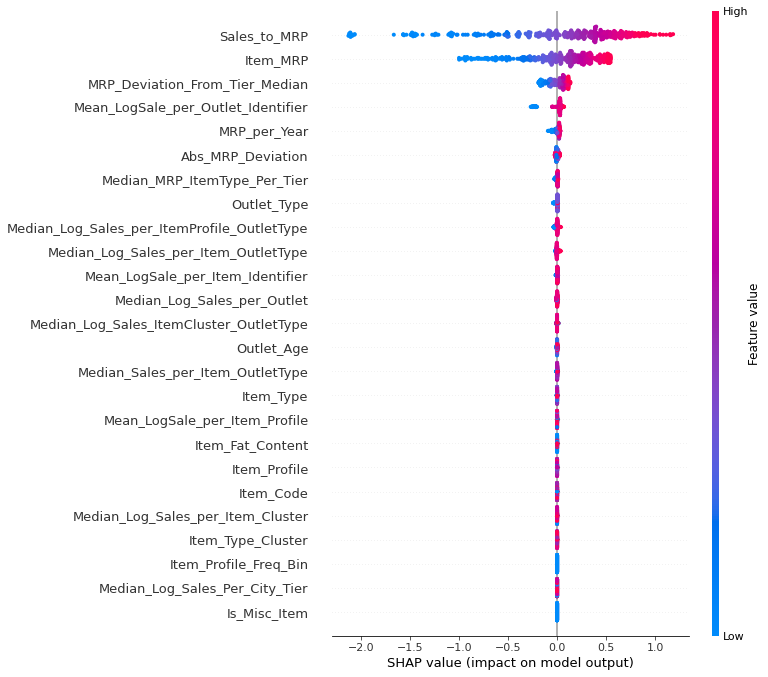

In [279]:
shap.plots.beeswarm(shap_values, max_display=30)



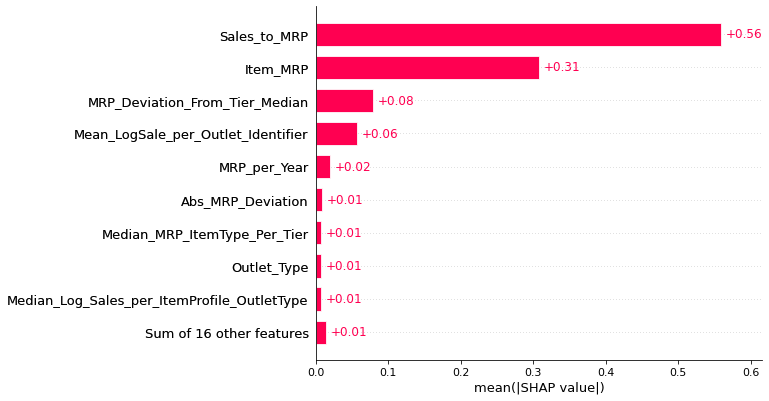

In [280]:
shap.plots.bar(shap_values)


In [281]:
# Calculate mean absolute SHAP values per feature
shap_importance = np.abs(shap_values.values).mean(axis=0)

# Create a DataFrame with feature names and their importance
shap_df = pd.DataFrame({
    'Feature': X_val_encoded.columns,
    'Mean_SHAP_Importance': shap_importance
})

# Sort by importance
shap_df = shap_df.sort_values(by='Mean_SHAP_Importance', ascending=False)

# Display top 20
print(shap_df.head(20))


                                        Feature  Mean_SHAP_Importance
9                                  Sales_to_MRP              0.558361
5                                      Item_MRP              0.307398
21               MRP_Deviation_From_Tier_Median              0.079220
7            Mean_LogSale_per_Outlet_Identifier              0.056305
18                                 MRP_per_Year              0.019704
22                            Abs_MRP_Deviation              0.009097
20                 Median_MRP_ItemType_Per_Tier              0.007979
11                                  Outlet_Type              0.007678
17  Median_Log_Sales_per_ItemProfile_OutletType              0.006929
23         Median_Log_Sales_per_Item_OutletType              0.005109
6              Mean_LogSale_per_Item_Identifier              0.002839
15                  Median_Log_Sales_per_Outlet              0.001777
14      Median_Log_Sales_ItemCluster_OutletType              0.001352
12                  

In [282]:
list(shap_df['Feature'])

['Sales_to_MRP',
 'Item_MRP',
 'MRP_Deviation_From_Tier_Median',
 'Mean_LogSale_per_Outlet_Identifier',
 'MRP_per_Year',
 'Abs_MRP_Deviation',
 'Median_MRP_ItemType_Per_Tier',
 'Outlet_Type',
 'Median_Log_Sales_per_ItemProfile_OutletType',
 'Median_Log_Sales_per_Item_OutletType',
 'Mean_LogSale_per_Item_Identifier',
 'Median_Log_Sales_per_Outlet',
 'Median_Log_Sales_ItemCluster_OutletType',
 'Outlet_Age',
 'Median_Sales_per_Item_OutletType',
 'Item_Type',
 'Mean_LogSale_per_Item_Profile',
 'Item_Fat_Content',
 'Item_Profile',
 'Item_Code',
 'Median_Log_Sales_per_Item_Cluster',
 'Item_Type_Cluster',
 'Item_Profile_Freq_Bin',
 'Median_Log_Sales_Per_City_Tier',
 'Is_Misc_Item']

SHAP Score of a specific Feature

In [283]:
# import shap
# import pandas as pd

# # Suppose shap_values is already calculated using shap.TreeExplainer
# shap_values = explainer.shap_values(X_train_encoded)

# # Convert to DataFrame
# shap_df = pd.DataFrame(shap_values, columns=X_train_encoded.columns)

# # Get mean absolute SHAP value for a specific feature
# feature = 'Outl'
# mean_shap = shap_df[feature].abs().mean()

# print(f"Mean SHAP value for {feature}: {mean_shap:.5f}")


In [284]:
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
# print(categorical_columns)

for col in categorical_columns:
    train_vals = set(X_train[col].dropna().unique())
    test_vals = set(X_val[col].dropna().unique())
    diff = test_vals - train_vals
    if diff:
        print(f"New values in test for '{col}': {diff}")
